In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CellPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

/home/twhit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


image 1 
count
 4 
total fluor
 560.4500122070312


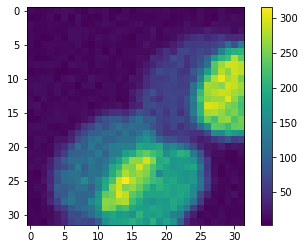

In [2]:
num_images = 1
img_dim = 32 # Needs to be square
img_height = img_dim
img_width = img_dim
max_objects = 4
psf_size = 5
psf_stdev = 1
background = 10

prior = CellPrior(max_objects, img_height, img_width, min_fluor = background)

image_attributes = ImageAttributes(img_height, img_width, max_objects, psf_size, psf_stdev, background)

true_counts, true_fluors, true_locs, true_axes, true_angles, true_total_intensities, images = image_attributes.generate(prior, num_images)

for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal fluor\n", true_fluors[i].sum().item())
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())
    plt.colorbar(_, ax=img)

In [3]:
tile_side_length = img_dim
max_objects_smc = 4

prior = CellPrior(max_objects_smc,
                  tile_side_length, tile_side_length,
                  min_fluor = background,
                  pad = 0)

smc = SMCsampler(images[0], image_attributes, tile_side_length, prior,
                 max_objects = max_objects_smc, catalogs_per_block = 2000,
                 kernel_num_iters = 100, product_form_multiplier = 500,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total fluorescence: {true_fluors[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 4
True total fluorescence: 560.4500122070312

Starting the tile samplers...
iteration 2, temperature = 0.00017694880079943687
iteration 4, temperature = 0.0007130894809961319
iteration 6, temperature = 0.0016756191616877913
iteration 8, temperature = 0.003203644184395671
iteration 10, temperature = 0.006064307410269976
iteration 12, temperature = 0.01160714216530323
iteration 14, temperature = 0.021961988881230354
iteration 16, temperature = 0.03900933638215065
iteration 18, temperature = 0.06468122452497482
iteration 20, temperature = 0.09938772022724152
iteration 22, temperature = 0.19651809334754944
iteration 24, temperature = 0.35398632287979126
Done!

summary
number of SMC iterations: 24
posterior mean count: 4.000000953674316
posterior mean total fluor: 557.6962890625



